In [1]:
from gluonts.dataset.repository import get_dataset

from normalizer import GASComplexGaussian
from utils import create_dataset_for_mean_layer

import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import os

# Get the dataset and manipulate it

In [2]:
# GET THE DATASET
DATASET_NAME = "nn5_weekly"
dataset = get_dataset(DATASET_NAME)
len(dataset.train), len(dataset.test)

(111, 111)

We will save some figures in some folders. Let's initialize folder names

In [3]:
root_folder = 'figures_from_test_gas/'
dataset_folder = root_folder + DATASET_NAME + '/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

Done

In [4]:
len(set([el["target"].shape[0] for el in dataset.train]))   # lengths in the train dataset must be equal

1

In [5]:
prediction_length = dataset.metadata.prediction_length
context_length = 2 * prediction_length
freq = dataset.metadata.freq

prediction_length, context_length, freq

(8, 16, 'W')

# Warm up GAS normalizer (compute static parameters and pre-compute means and variances)

In [6]:
normalizer = GASComplexGaussian()
# we must warm up the normalizer with the complete list of test time series (test because they are the longest)
normalizer.warm_up([el['target'] for el in dataset.train], [el['target'] for el in dataset.test])   # normalizer wants list of arrays

normalizer.__dict__

Optimal parameters:  alpha_mean = 0.0011660740371621586,  alpha_sigma = 0.001, mean_0 = 0.9999999862096192, sigma2_0 = 1.0


{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'means': [array([[ 1.1643748],
         [ 1.3504219],
         [ 1.5415994],
         [ 1.71896  ],
         [ 1.889173 ],
         [ 2.0039575],
         [ 2.2172353],
         [ 2.3852477],
         [ 2.5631616],
         [ 2.7011395],
         [ 2.889526 ],
         [ 3.0763707],
         [ 3.2287228],
         [ 3.4187913],
         [ 3.6011024],
         [ 3.7981899],
         [ 3.9889824],
         

In [7]:
means, _ = normalizer.get_means_and_vars()
tr_means = [m[:-prediction_length] for m in means]

Plot the time series as well as means computed by GAS

In [8]:
means[0].shape, list(dataset.test)[0]['target'].shape

((113, 1), (113,))

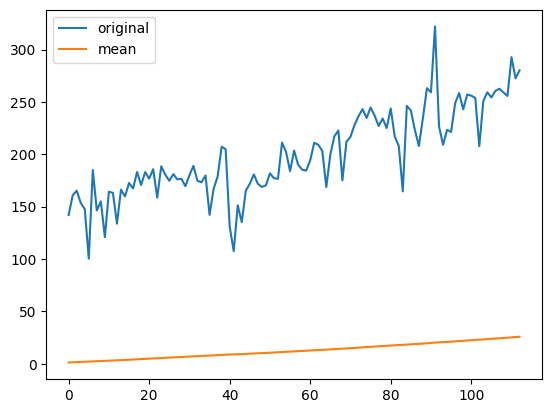

In [9]:
ts_0 = list(dataset.test)[0]["target"]
mean_0 = means[0].squeeze()

ts_len = ts_0.shape[0]

plt.plot(range(ts_len), ts_0, label="original")
plt.plot(range(ts_len), mean_0, label="mean")
plt.legend()
plt.show()

# Normalized the time series

In [10]:
norm_ts_train_list = normalizer.normalize([el['target'] for el in dataset.train])   # normalizer wants list of arrays
norm_ts_test_list = normalizer.normalize([el['target'] for el in dataset.test])
norm_ts_train_list[0].shape, norm_ts_test_list[0].shape

((105,), (113,))

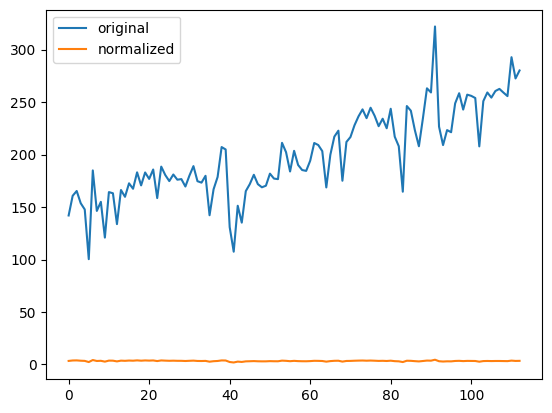

In [11]:
norm_ts_test_0 = norm_ts_test_list[0]
len_ts = norm_ts_test_0.shape[0]

plt.plot(range(len_ts), ts_0, label="original")
plt.plot(range(len_ts), norm_ts_test_0, label="normalized")
plt.legend()
plt.show()

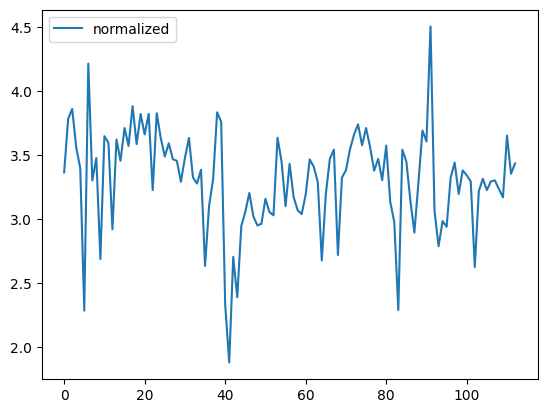

In [12]:
norm_ts_test_0 = norm_ts_test_list[0]
len_ts = norm_ts_test_0.shape[0]

plt.plot(range(len_ts), norm_ts_test_0, label="normalized")
plt.legend()
plt.show()

# Train mean layer

In [13]:
N_TRAINING_SAMPLES_PER_TS = 10
N_TEST_SAMPLES_PER_TS = 10

list_train_ts = [el['target'] for el in dataset.train]
list_test_ts = [el['target'] for el in dataset.test]
list_train_mean = [el.squeeze() for el in tr_means]   # squeeze just to be sure its shape is (ts_len,)
list_test_mean = [el.squeeze() for el in means]   # squeeze just to be sure its shape is (ts_len,)

train_means_xs, train_means_ys = create_dataset_for_mean_layer(list_train_ts, list_train_mean, context_length, prediction_length, N_TRAINING_SAMPLES_PER_TS)
test_means_xs, test_means_ys = create_dataset_for_mean_layer(list_test_ts, list_test_mean, context_length, prediction_length, N_TEST_SAMPLES_PER_TS)

train_means_xs.shape, train_means_ys.shape, test_means_xs.shape, test_means_ys.shape

((1110, 16), (1110, 8), (1110, 16), (1110, 8))

In [14]:
regr = linear_model.LinearRegression()
regr.fit(train_means_xs, train_means_ys)

regr.score(test_means_xs, test_means_ys)

0.7156296089994696

Now let's compute the predicted time series

In [15]:
pred_ts_list = []

for ts, mean_ts in zip(list_test_ts, list_test_mean):
    ts_len = ts.shape[0]

    pred_ts = []
    # first context_length values are the means
    pred_ts.extend(mean_ts[:context_length].tolist())
    # then we predict only the following elements
    for i in range(context_length, ts_len - prediction_length):
        pred_ts.append(regr.predict(mean_ts[i-context_length:i].reshape(1, -1))[0][0])
    # at the end we predict the last prediction_length elements
    pred_ts.extend(regr.predict(mean_ts[-context_length:].reshape(1, -1))[0].tolist())
    pred_ts_list.append(pred_ts)

pred_ts_list = np.array(pred_ts_list)
pred_ts_list.shape

(111, 113)

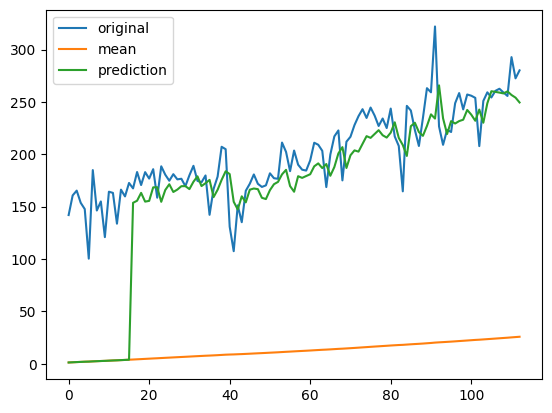

In [16]:
ts_0 = list_test_ts[0]
mean_0 = list_test_mean[0]
pred_0 = pred_ts_list[0]
len_ts = ts_0.shape[0]

plt.plot(range(len_ts), ts_0, label="original")
plt.plot(range(len_ts), mean_0, label="mean")
plt.plot(range(len_ts), pred_0, label="prediction")
plt.legend()
plt.show()

# Plot and save the figures

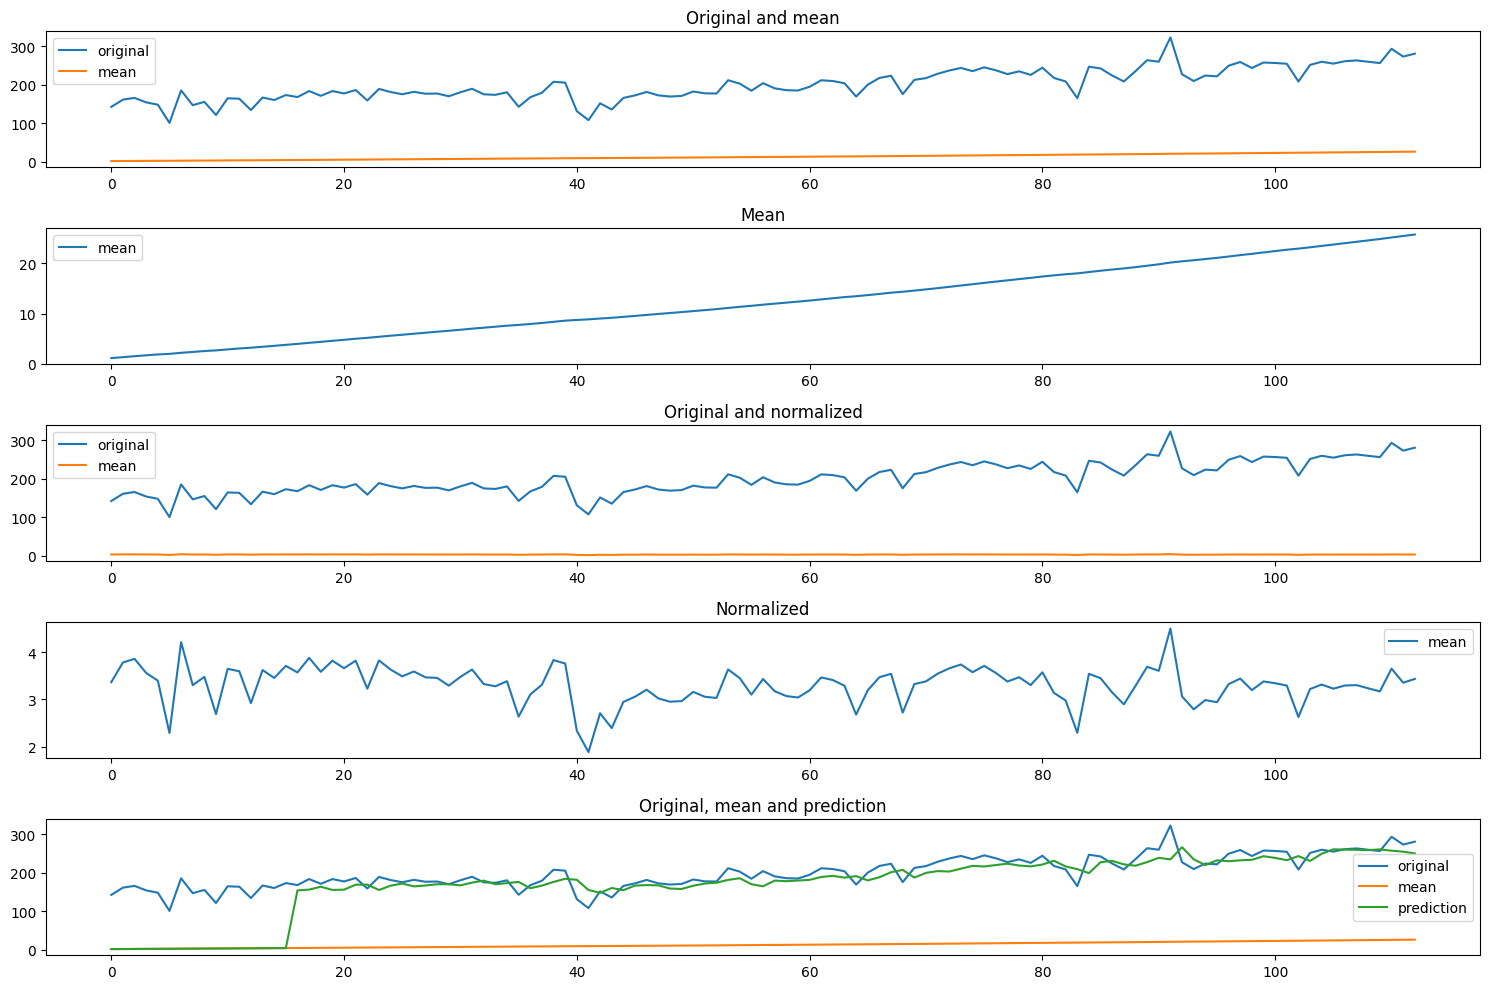

In [17]:
# plot an example of the final figure
ts_0 = list_test_ts[0]
mean_0 = list_test_mean[0]
pred_0 = pred_ts_list[0]
norm_0 = norm_ts_test_list[0]

len_ts = ts_0.shape[0]

fig, axis = plt.subplots(5, 1, figsize=(15, 10))

axis[0].plot(range(ts_len), ts_0, label="original")
axis[0].plot(range(ts_len), mean_0, label="mean")
axis[0].legend()
axis[0].set_title("Original and mean")

axis[1].plot(range(ts_len), mean_0, label="mean")
axis[1].legend()
axis[1].set_title("Mean")

axis[2].plot(range(ts_len), ts_0, label="original")
axis[2].plot(range(ts_len), norm_0, label="mean")
axis[2].legend()
axis[2].set_title("Original and normalized")

axis[3].plot(range(ts_len), norm_0, label="mean")
axis[3].legend()
axis[3].set_title("Normalized")

axis[4].plot(range(ts_len), ts_0, label="original")
axis[4].plot(range(ts_len), mean_0, label="mean")
axis[4].plot(range(ts_len), pred_0, label="prediction")
axis[4].legend()
axis[4].set_title("Original, mean and prediction")
plt.tight_layout()
plt.show()

In [18]:
# set max number of figures to be saved
MAX_FIG = 20
# select randomly MAX_FIG figures to make
idxs = np.random.choice(len(list_test_ts), MAX_FIG, replace=False)

for idx in idxs:
    ts_i = list_test_ts[idx]
    mean_i = list_test_mean[idx]
    pred_i = pred_ts_list[idx]
    norm_i = norm_ts_test_list[idx]

    ts_len = ts_i.shape[0]

    fig, axis = plt.subplots(5, 1, figsize=(15, 10))

    axis[0].plot(range(ts_len), ts_i, label="original")
    axis[0].plot(range(ts_len), mean_i, label="mean")
    axis[0].legend()
    axis[0].set_title("Original and mean")

    axis[1].plot(range(ts_len), mean_i, label="mean")
    axis[1].legend()
    axis[1].set_title("Mean")

    axis[2].plot(range(ts_len), ts_i, label="original")
    axis[2].plot(range(ts_len), norm_i, label="mean")
    axis[2].legend()
    axis[2].set_title("Original and normalized")

    axis[3].plot(range(ts_len), norm_i, label="mean")
    axis[3].legend()
    axis[3].set_title("Normalized")

    axis[4].plot(range(ts_len), ts_i, label="original")
    axis[4].plot(range(ts_len), mean_i, label="mean")
    axis[4].plot(range(ts_len), pred_i, label="prediction")
    axis[4].legend()
    axis[4].set_title("Original, mean and prediction")

    plt.tight_layout()
    plt.savefig(dataset_folder + f'ts_{idx}.png')
    plt.close()